**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [3]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/toxoplasma_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 24479 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [4]:
Idents(anndata)= anndata$cell_type

In [5]:
head(Idents(anndata))

Pla_HDBR13007976_AAACCCAAGCCTCATA Pla_HDBR13007976_AAACCCAAGCTGTTAC 
                              HBC                        VCT_fusing 
Pla_HDBR13007976_AAACCCAAGGCATCAG Pla_HDBR13007976_AAACCCACACTAAACC 
                              HBC                        VCT_fusing 
Pla_HDBR13007976_AAACCCACACTACGGC Pla_HDBR13007976_AAACCCACAGCAGTCC 
                       VCT_fusing                        VCT_fusing 
14 Levels: EVT_1 EVT_2 Endo_f F F_p HBC HBC_p PAMM1 PV VCT ... iEVT

# Fibroblasts and Endo_f

In [6]:
fibroEndo= subset(x = anndata, idents = c('F','PV','Endo_f'))

Idents(object = fibroEndo) <- "infection"


#fixing levels
fibroEndo$celltype.Stage = factor(fibroEndo$celltype.Stage, levels = c("F-Tg_48h", "F-UI_Tg_48h", "PV-Tg_48h","PV-UI_Tg_48h", "Endo_f-Tg_48h","Endo_f-UI_Tg_48h"))
fibroEndo$cell_type<- factor(fibroEndo$cell_type, levels = c("F","PV","Endo_f"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
fibroEndo$infection<- factor(fibroEndo$infection, levels = c("UI","Tg"))

In [7]:
fibroEndo$classification = paste(fibroEndo$cell_type, fibroEndo$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = fibroEndo, features = rownames(fibroEndo), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [8]:
head(percent_mat)

,Endo_f-Tg,Endo_f-UI,F-Tg,F-UI,PV-Tg,PV-UI
AC115284.3,0.00000000,0.0000000,0.06108735,0.05586592,0.0000000,0.1855288
RNF186,0.00000000,0.0000000,0.00000000,0.00000000,0.0000000,0.0000000
FMR1,30.43844857,32.7122153,31.82651191,36.92737430,29.4994675,32.9004329
CANX,92.66441821,93.0986888,93.58582773,95.58659218,93.6102236,93.3828077
ZNF84-DT,0.08431703,0.2070393,0.30543677,0.27932961,0.2129925,0.1855288
LIPA,46.29005059,45.8247067,20.40317654,22.40223464,25.9850905,29.2517007


In [9]:
#print(Idents(VCT_fusing))

In [10]:
table(fibroEndo[["celltype.Stage"]] )


        F-Tg_48h      F-UI_Tg_48h        PV-Tg_48h     PV-UI_Tg_48h 
            1637             1790              939             1617 
   Endo_f-Tg_48h Endo_f-UI_Tg_48h 
            1186             1449 

In [11]:
anndata_sce <- as.SingleCellExperiment(fibroEndo)

In [12]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 8618 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(8618): Pla_HDBR13007976_AAACCCAGTACCGCGT
  Pla_HDBR13007976_AAACGCTAGCTCGACC ...
  Pla_HDBR13798226_TTTGTTGCACGACAGA Pla_HDBR13798226_TTTGTTGTCATCACAG
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [13]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Tg-Endo_f-scDonor_Tg1-1,Tg-Endo_f-scDonor_Tg1-2,Tg-Endo_f-scDonor_Tg1-3,Tg-Endo_f-scDonor_Tg2-1,Tg-Endo_f-scDonor_Tg2-2,Tg-Endo_f-scDonor_Tg2-3,Tg-Endo_f-scDonor_Tg3-1,Tg-Endo_f-scDonor_Tg3-2,Tg-Endo_f-scDonor_Tg3-3,Tg-Endo_f-scDonor_Tg4-1,⋯,UI-PV-scDonor_Tg1-3,UI-PV-scDonor_Tg2-1,UI-PV-scDonor_Tg2-2,UI-PV-scDonor_Tg2-3,UI-PV-scDonor_Tg3-1,UI-PV-scDonor_Tg3-2,UI-PV-scDonor_Tg3-3,UI-PV-scDonor_Tg4-1,UI-PV-scDonor_Tg4-2,UI-PV-scDonor_Tg4-3
AC115284.3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,1,0,0,2,0,0,0,0
RNF186,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
FMR1,11,11,11,31,28,28,64,69,77,60,⋯,24,78,63,59,47,44,62,83,110,79



Endo_f-Tg Endo_f-UI      F-Tg      F-UI     PV-Tg     PV-UI 
       12        12        12        12        12        12 


UI Tg 
36 36 

In [14]:
summed

class: SingleCellExperiment 
dim: 36601 72 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(72): Tg-Endo_f-scDonor_Tg1-1 Tg-Endo_f-scDonor_Tg1-2 ...
  UI-PV-scDonor_Tg4-2 UI-PV-scDonor_Tg4-3
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [15]:
summed$infection<- factor(summed$infection, levels = c( "UI","Tg"))

In [16]:
table(summed$infection)


UI Tg 
36 36 

### Corrected by genotype

In [17]:
DEGs_list = list()

In [18]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "Endo_f"
[1] "F"
[1] "PV"


In [19]:
##  Saving the DEG matrix

write.table(DEGs_list[["F"]],'../results/SC_limma_fibroEndo_TOX_48h/1_DEGs_SC_TOX_48h_F.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["PV"]],'../results/SC_limma_fibroEndo_TOX_48h/2_DEGs_SC_TOX_48h_PV.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["Endo_f"]],'../results/SC_limma_fibroEndo_TOX_48h/3_DEGs_SC_TOX_48h_Endof.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)



In [20]:
#colData(summed_celltype)$metacell_id

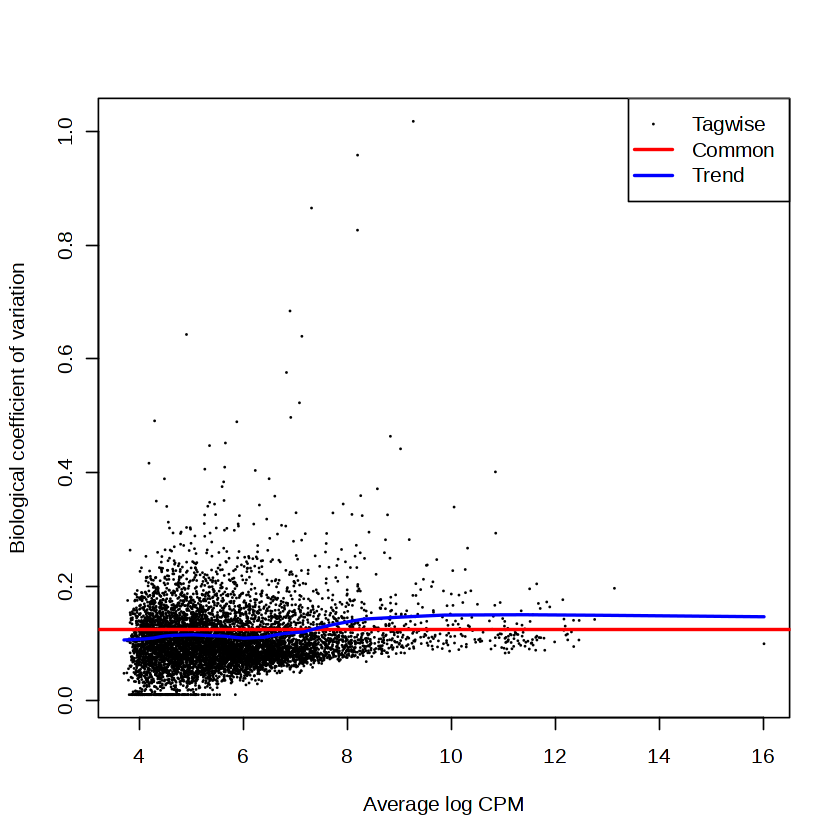

In [21]:
plotBCV(y)

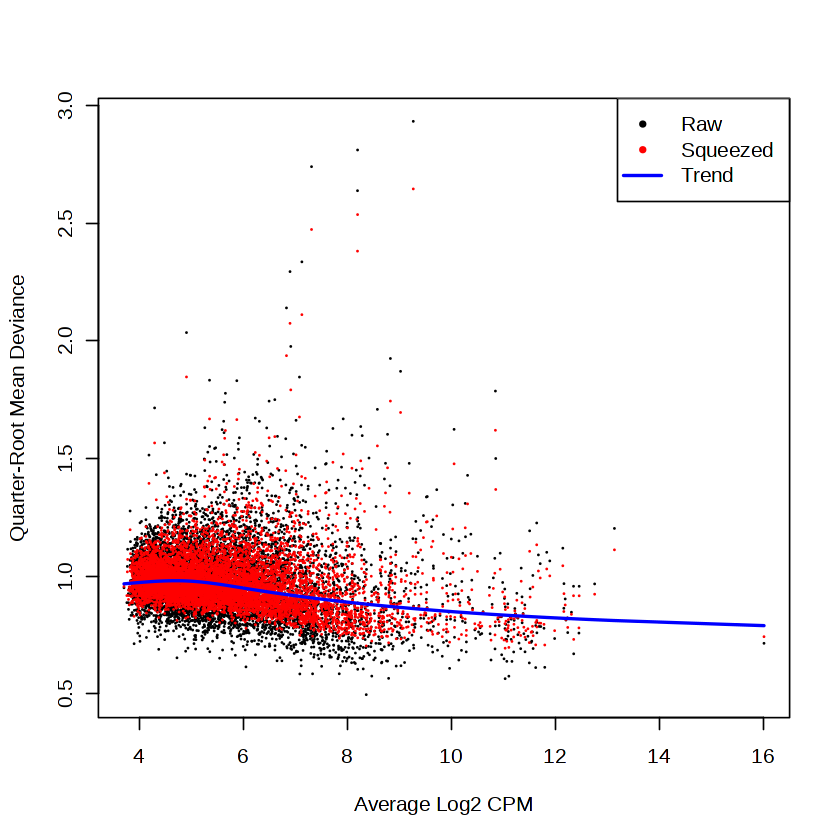

In [22]:
plotQLDisp(fit)

In [23]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Tg-PV-scDonor_Tg1-1,Tg-PV-scDonor_Tg1-2,Tg-PV-scDonor_Tg1-3,Tg-PV-scDonor_Tg2-1,Tg-PV-scDonor_Tg2-2,Tg-PV-scDonor_Tg2-3,Tg-PV-scDonor_Tg3-1,Tg-PV-scDonor_Tg3-2,Tg-PV-scDonor_Tg3-3,Tg-PV-scDonor_Tg4-1,⋯,UI-PV-scDonor_Tg1-3,UI-PV-scDonor_Tg2-1,UI-PV-scDonor_Tg2-2,UI-PV-scDonor_Tg2-3,UI-PV-scDonor_Tg3-1,UI-PV-scDonor_Tg3-2,UI-PV-scDonor_Tg3-3,UI-PV-scDonor_Tg4-1,UI-PV-scDonor_Tg4-2,UI-PV-scDonor_Tg4-3
CGA,472.281145,597.61431,308.019775,303.945362,314.656047,350.861458,256.23688,350.351207,383.42418,379.096602,⋯,207.234802,241.605608,229.532746,242.050754,178.311810,197.186081,135.524493,142.237531,142.494771,147.005820
MT-ND3,4569.582461,4884.47831,3416.452676,3856.432037,3375.611562,4484.283382,2910.66435,2736.327346,2755.29220,3324.316152,⋯,1815.243883,3415.587430,3449.347486,3391.508832,2079.607236,1928.809399,1886.457403,2149.995703,2380.170623,2206.249399
KISS1,56.673737,98.47054,43.636135,46.760825,50.129027,63.218281,20.78743,4.748736,13.65759,7.220888,⋯,6.649245,12.825977,11.300074,10.143745,9.412354,5.846488,9.252676,7.004121,9.891757,6.682083
DUXAP8,6.297082,11.88438,17.967820,72.813285,44.730516,35.823692,31.39326,27.437143,32.37355,34.299216,⋯,15.514905,23.265725,37.078367,30.781021,21.439250,18.070962,14.695427,18.318470,12.030515,16.850469
CSH1,48.277628,76.39956,33.368809,72.145273,32.391064,54.789177,58.54419,56.984835,82.95721,83.040208,⋯,1.108207,9.544913,14.831347,8.045040,43.924317,31.889932,46.263381,60.073805,49.993475,40.383022
DSP,31.485410,33.95536,30.801978,120.242121,106.427781,143.294770,80.18008,86.004890,63.73542,100.189816,⋯,47.652922,167.334254,157.141649,124.523220,99.352621,113.209259,128.448917,111.257765,127.523463,123.473268
SLC7A11,159.526076,106.95938,71.871281,59.453049,72.494285,79.022851,51.33222,41.155714,40.97277,33.396605,⋯,18.839527,53.690135,35.312730,43.023472,25.622518,23.917449,18.505352,27.208315,20.852893,13.654691
ISG15,41.980546,47.53750,53.903461,37.408660,55.527538,57.950091,160.78440,156.708296,163.38524,61.377545,⋯,57.626790,73.674797,53.675350,76.252983,330.478193,325.277308,276.491737,61.151363,75.123885,91.806006
MT-ATP8,253.982305,348.04242,143.742562,183.703241,171.981124,175.957548,120.05801,94.447087,140.11675,130.878589,⋯,88.656600,161.070405,145.488448,124.873005,90.986085,98.858790,85.995462,89.437235,93.035985,90.353379
NMT1,98.654284,84.88840,110.373753,132.934345,123.394528,143.294770,58.11996,57.512472,68.79378,69.501044,⋯,53.193960,79.938646,78.394261,87.446082,48.630494,51.023892,57.693158,72.735101,63.628059,62.753473


In [24]:
summary(decideTests(qlf))

       summed_celltype$infectionTg
Down                            15
NotSig                        7422
Up                              35

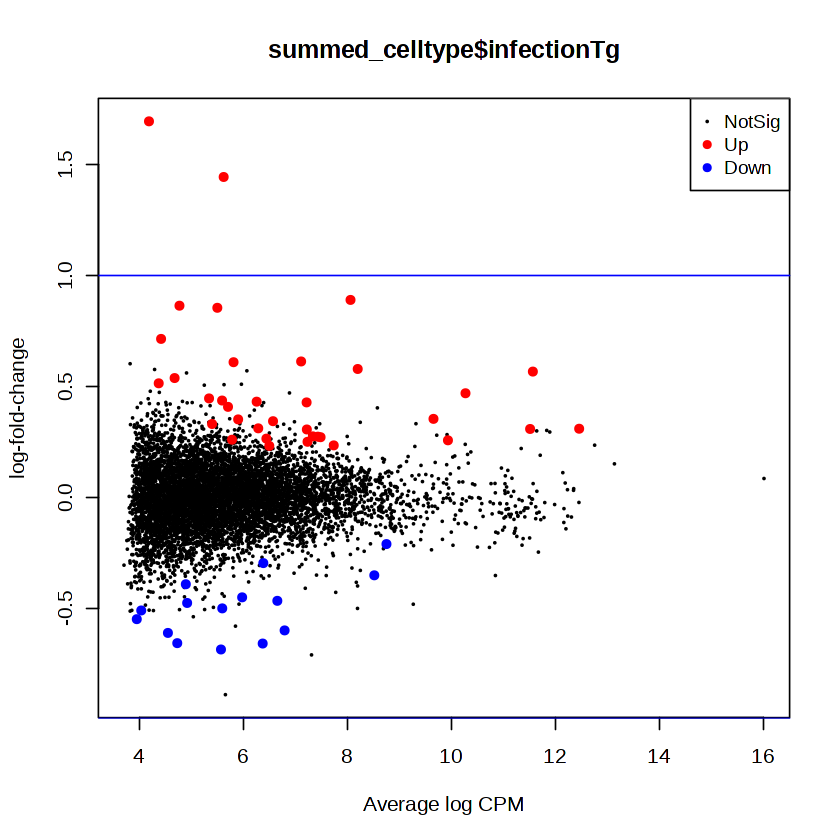

In [25]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

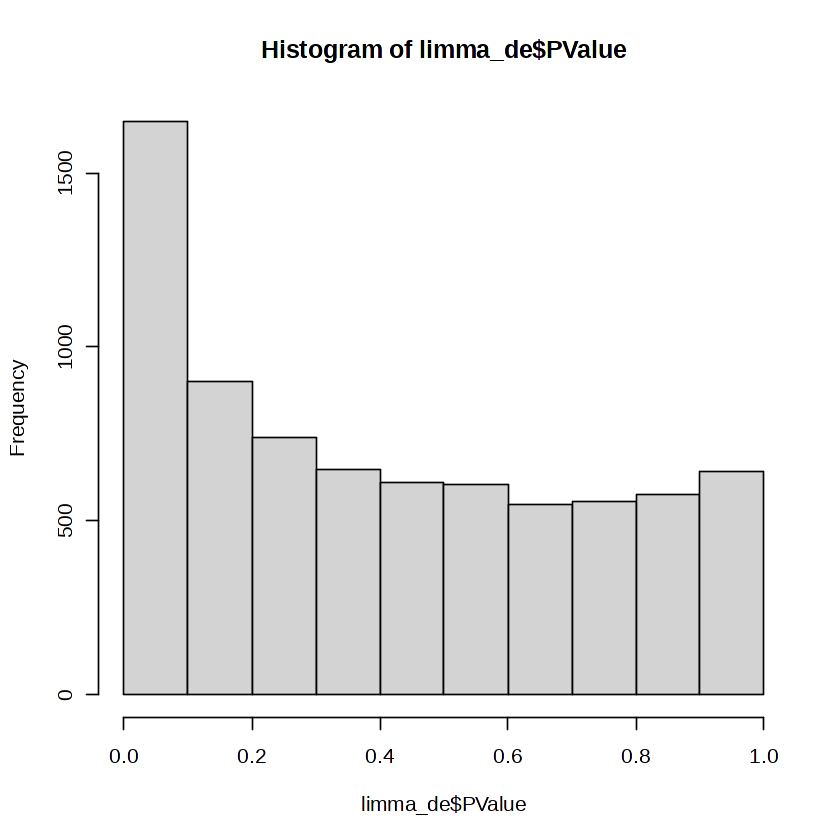

In [35]:
limma_de = qlf$table
limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(limma_de$PValue)

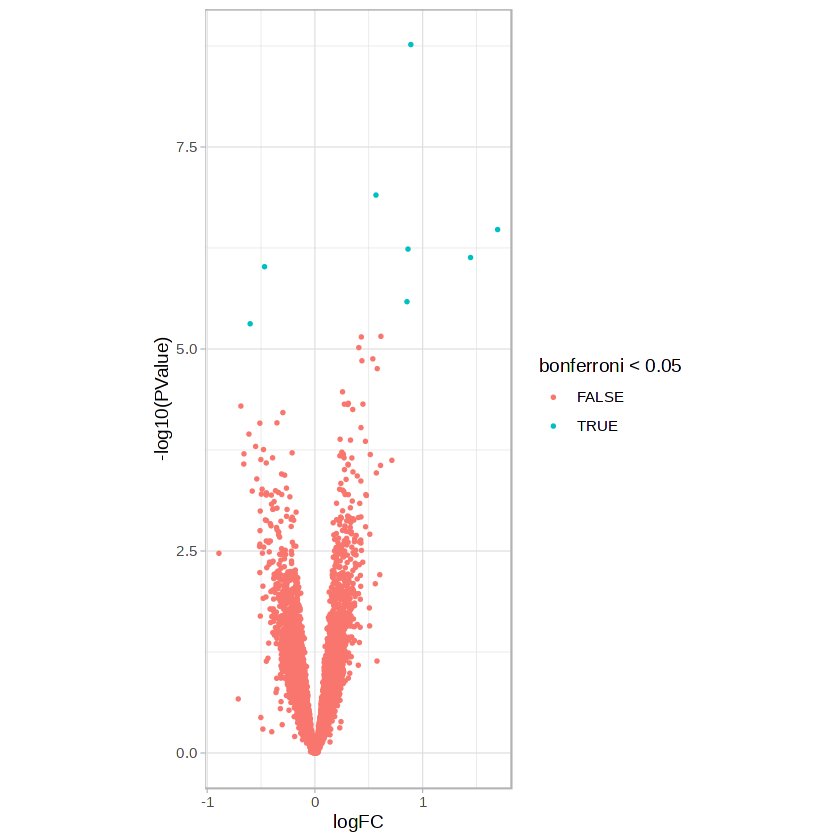

In [36]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = bonferroni < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

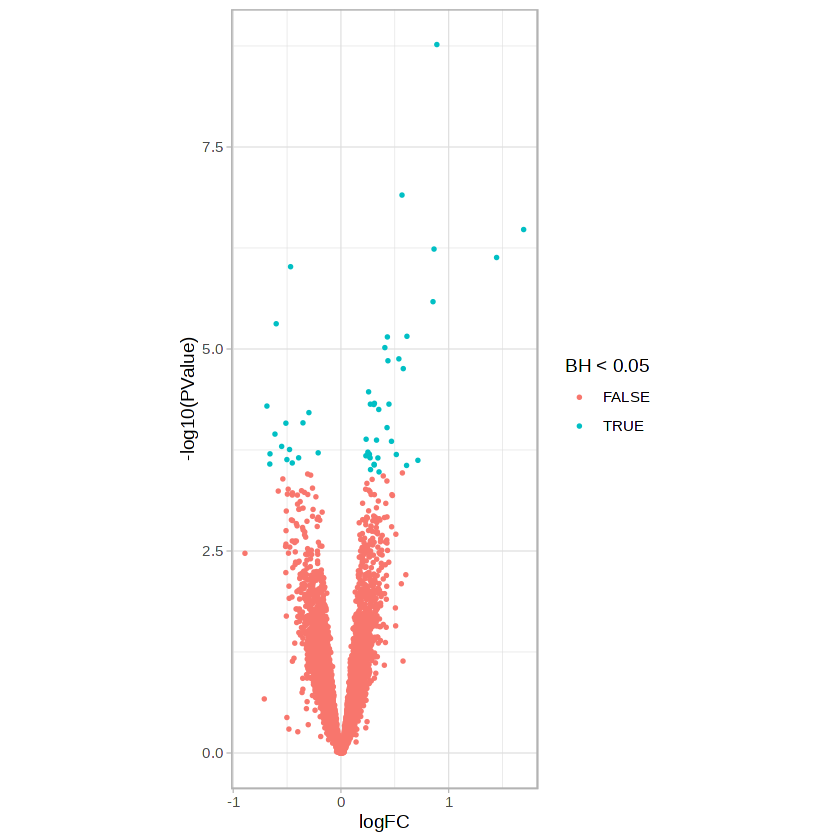

In [37]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
